In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as np

%matplotlib inline

# Create own dataset
## Data: Customer counts per date

In [4]:
np.seed(111)

In [5]:
def CreateDataSet(Number=1):
    Output = []
    
    for i in range(Number):
        #Create a list with Weekly Dates. See: W-MON
        rng = pd.date_range(start='1/1/2009', end='12/31/2012', freq='W-MON')
        
        data = np.randint(low=25, high=1000, size=len(rng))
        
        status = [1, 2, 3]
        
        random_status = [status[np.randint(low=0, high=len(status))] for i in range(len(rng))]
        
        states = ['GA', 'FL', 'fl', 'NY', 'NJ', 'TX']
        
        random_states = [states[np.randint(low=0, high=len(states))] for i in range(len(rng))]
        
        dataset = zip(random_states, random_status, data, rng)
        
        Output.extend(dataset)
    
    return Output

In [6]:
dataset = CreateDataSet(4)

In [7]:
df = pd.DataFrame(dataset, columns=['State', 'Status', 'CustomerCount', 'StatusDate'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836 entries, 0 to 835
Data columns (total 4 columns):
State            836 non-null object
Status           836 non-null int64
CustomerCount    836 non-null int64
StatusDate       836 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 26.2+ KB


In [9]:
df.head()

,State,Status,CustomerCount,StatusDate
0,GA,1,877,2009-01-05
1,FL,1,901,2009-01-12
2,fl,3,749,2009-01-19
3,FL,3,111,2009-01-26
4,GA,1,300,2009-02-02


## Save to Excel

In [10]:
df.to_excel('Lesson3.xlsx', index=False)

## Get data from Excel

In [11]:
df = pd.read_excel('Lesson3.xlsx', index_col='StatusDate')

In [12]:
df.head()

,State,Status,CustomerCount
StatusDate,,,
2009-01-05,GA,1,877
2009-01-12,FL,1,901
2009-01-19,fl,3,749
2009-01-26,FL,3,111
2009-02-02,GA,1,300


In [13]:
df.dtypes

State            object
Status            int64
CustomerCount     int64
dtype: object

In [14]:
df.index

DatetimeIndex(['2009-01-05', '2009-01-12', '2009-01-19', '2009-01-26',
               '2009-02-02', '2009-02-09', '2009-02-16', '2009-02-23',
               '2009-03-02', '2009-03-09',
               ...
               '2012-10-29', '2012-11-05', '2012-11-12', '2012-11-19',
               '2012-11-26', '2012-12-03', '2012-12-10', '2012-12-17',
               '2012-12-24', '2012-12-31'],
              dtype='datetime64[ns]', name=u'StatusDate', length=836, freq=None)

# Cleanup data and prepare for analysis

In [15]:
df['State'].unique()

array([u'GA', u'FL', u'fl', u'TX', u'NY', u'NJ'], dtype=object)

## Clean State Column

### Convert all states to uppercase

In [16]:
df['State'] = df.State.apply(lambda x: x.upper())

In [17]:
df['State'].unique()

array([u'GA', u'FL', u'TX', u'NY', u'NJ'], dtype=object)

### Change NJ to NY

In [18]:
mask = df['State'] == 'NJ'

# df['State'][mask] = 'NY' is avoided. TODO: Why?
df.loc[mask, 'State'] = 'NY'

In [19]:
df.State.unique()

array([u'GA', u'FL', u'TX', u'NY'], dtype=object)

## Plot the customer count on graph

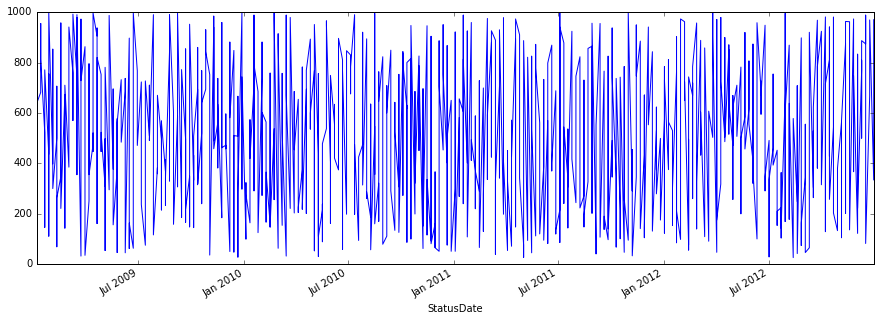

In [20]:
df['CustomerCount'].plot(figsize=(15,5))

## Grouping of data

In [21]:
# Reindex and bring StatusDate back to column instead of index
Daily = df.reset_index()

# Group all the customers according to state and the date
Daily = Daily.groupby(['State','StatusDate']).sum()

In [22]:
Daily.head()

Status  CustomerCount
State StatusDate                       
FL    2009-01-05       6            760
      2009-01-12       7           2538
      2009-01-19       6            895
      2009-01-26       6            547
      2009-02-02       4           1506

In [23]:
# Remove the Status column as we do not need it
del Daily['Status']

In [24]:
Daily.head()

CustomerCount
State StatusDate               
FL    2009-01-05            760
      2009-01-12           2538
      2009-01-19            895
      2009-01-26            547
      2009-02-02           1506

In [25]:
# Gives the insights to the how many level are there: 2 (State and Date)
# Daily.index

In [26]:
States = Daily.index.levels[0]
States

Index([u'FL', u'GA', u'NY', u'TX'], dtype='object', name=u'State')

In [27]:
Daily.index.levels[1]

DatetimeIndex(['2009-01-05', '2009-01-12', '2009-01-19', '2009-01-26',
               '2009-02-02', '2009-02-09', '2009-02-16', '2009-02-23',
               '2009-03-02', '2009-03-09',
               ...
               '2012-10-29', '2012-11-05', '2012-11-12', '2012-11-19',
               '2012-11-26', '2012-12-03', '2012-12-10', '2012-12-17',
               '2012-12-24', '2012-12-31'],
              dtype='datetime64[ns]', name=u'StatusDate', length=209, freq=None)

In [28]:
CreatePlotStateWise = lambda state: Daily.loc[state].plot(figsize=(15,5))

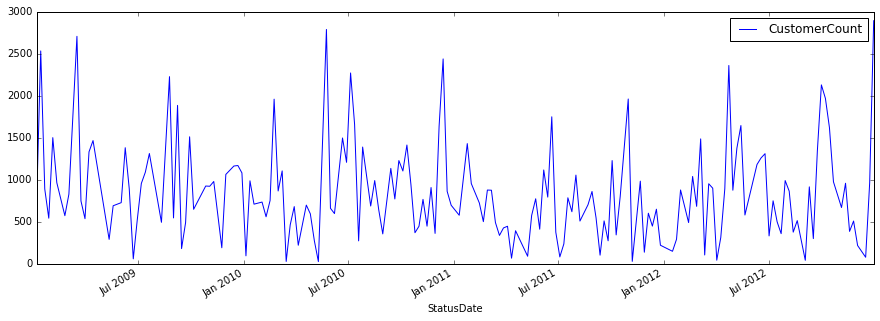

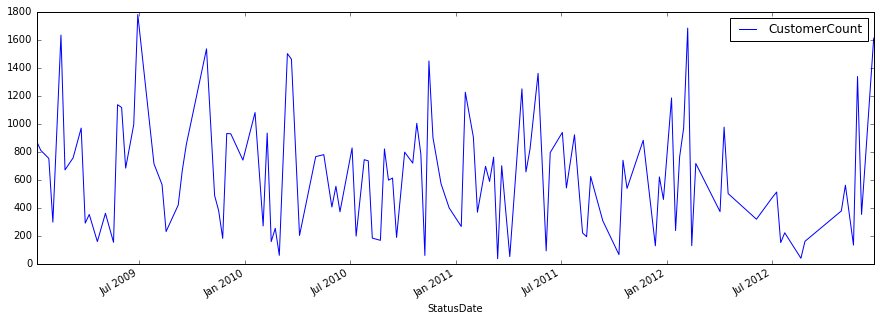

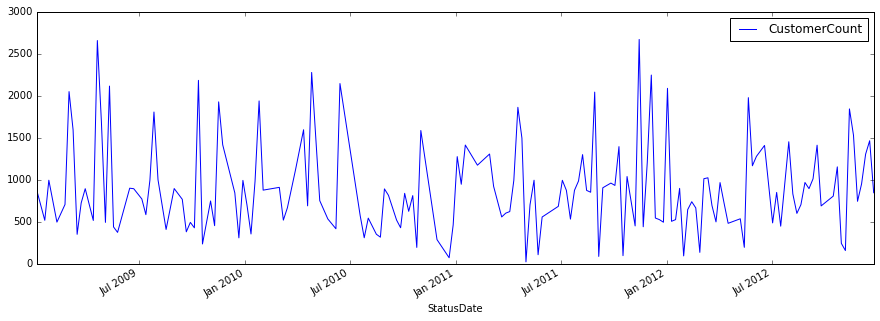

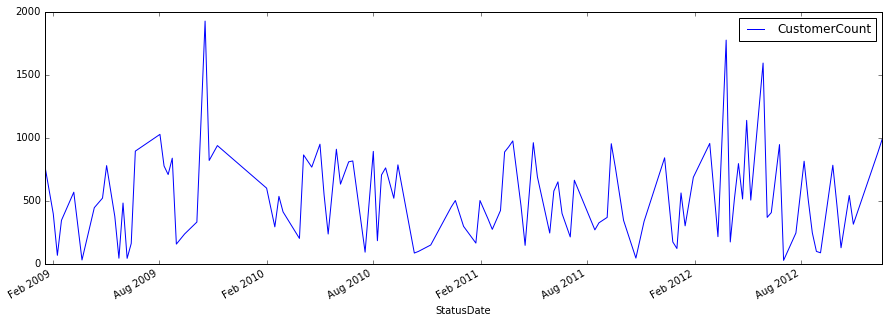

In [29]:
for state in States:
    CreatePlotStateWise(state)

## Group data by State, Year and Month

In [37]:
StateYearMonth = Daily.groupby([Daily.index.get_level_values(0),
                                Daily.index.get_level_values(1).year,
                                Daily.index.get_level_values(1).month])

Daily['Lower'] = StateYearMonth['CustomerCount'].transform(
                    lambda x: x.quantile(0.25) - (1.5*x.quantile(.75)-x.quantile(.25)))
Daily['Upper'] = StateYearMonth['CustomerCount'].transform(
                    lambda x: x.quantile(0.75) + (1.5*x.quantile(.75)-x.quantile(.25)))
Daily['Outlier'] = (Daily['CustomerCount'] < Daily['Lower']) | (Daily['CustomerCount'] > Daily['Upper'])

Daily = Daily[Daily['Outlier'] == False]

In [61]:
Daily.head()

CustomerCount    Lower     Upper Outlier
State StatusDate                                          
FL    2009-01-05            760 -545.125  2557.625   False
      2009-01-12           2538 -545.125  2557.625   False
      2009-01-19            895 -545.125  2557.625   False
      2009-01-26            547 -545.125  2557.625   False
      2009-02-02           1506 -310.250  2320.750   False

### Create new data frame ALL having CustomerCount as all customers on particular date

In [151]:
# ALL = pd.DataFrame(Daily['CustomerCount']).reset_index().groupby(['StatusDate']).sum()
ALL = pd.DataFrame(Daily['CustomerCount'].groupby(Daily.index.get_level_values(1)).sum())

# YearMonth groupby object
# lambda x automatically uses first column
YearMonth = ALL.groupby([lambda x: x.year, lambda x: x.month])

# Saves Max customer count each month of each year
ALL['Max'] = YearMonth['CustomerCount'].transform(lambda x: x.max())
ALL.head()

,CustomerCount,Max
StatusDate,,
2009-01-05,2519,3351
2009-01-12,3351,3351
2009-01-19,2188,3351
2009-01-26,2301,3351
2009-02-02,2204,2204
